# RANS Airfoil Flows with Bayesian Neural Nets

## Overview

We are looking at the same setup as in the notebook {doc}`supervised-airfoils`: A turbulent airflow around wing profiles, for which we'd like to know the average motion
and pressure distribution around this airfoil for different Reynolds numbers and angles of attack. In the other notebook, we tackled this by completely bypassing any physical solver and instead training a neural network that learns the quantities of interest. Now, we want to extend this approach to so-called Bayesian Neural Networks (short: BNNs). In contrast to traditional networks, that learn a single point estimate for each weight value, BNNs aim at learning a _distribution_ over each weight parameter (e.g. a Gaussian with mean $\mu$ and variance $\sigma^{2}$). During a forward-pass, each parameter in the network is then sampled from its corresponding approximate posterior distribution $q_{\phi}(\theta)$. In that sense, the network parameters themselves are _random variables_ and each forward pass becomes _stochastic_, because for a given input the predictions will vary with every forward-pass. This allows to assess how _uncertain_ the network is: If the predictions vary a lot, we think that the network is uncertain about its output. 

### Read in Data
Like in the previous notebook we'll skip the data generation process. This example is adapted from [this codebase](https://github.com/thunil/Deep-Flow-Prediction), which you can check out for details. Here, we'll simply download a small set of training data generated with a Spalart-Almaras RANS simulation in [OpenFOAM](https://openfoam.org/).

In [ ]:
import numpy as np
import os.path, random

if True:
    # download
    if not os.path.isfile('data-airfoils.npz'):
        import urllib.request
        url="https://ge.in.tum.de/download/2019-deepFlowPred/data.npz"
        print("Downloading training data (300MB), this can take a few minutes the first time...")
        urllib.request.urlretrieve(url, 'data-airfoils.npz')
    npfile=np.load('data-airfoils.npz')
else:
    # alternative, save to google drive, and load from there:
    from google.colab import drive
    drive.mount('/content/gdrive')
    npfile=np.load('gdrive/My Drive/data-airfoils.npz')

print("Loaded data, {} training, {} validation samples".format(len(npfile["inputs"]),len(npfile["vinputs"])))
print("Size of the inputs array: "+format(npfile["inputs"].shape))

# reshape to channels_last for convencience
X_train = np.moveaxis(npfile["inputs"],1,-1)
y_train = np.moveaxis(npfile["targets"],1,-1)

X_val = np.moveaxis(npfile["vinputs"],1,-1)
y_val = np.moveaxis(npfile["vtargets"],1,-1)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Loaded data, 320 training, 80 validation samples
Size of the inputs array: (320, 3, 128, 128)


### Look at Data
Now we have some training data. We can look at it using the code we also used in the original notebook:


Here are all 3 inputs are shown at the top (mask,in x, in y) 
Side by side with the 3 output channels (p,vx,vy) at the bottom:


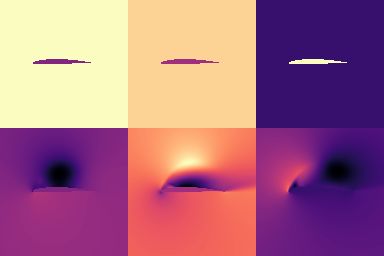

In [ ]:
from PIL import Image
from matplotlib import cm

# helper to show three target channels: normalized, with colormap, side by side
def showSbs(a1,a2, bottom="NN Output", top="Reference", title=None): 
  c=[]
  for i in range(3):
    b = np.flipud( np.concatenate((a2[i],a1[i]),axis=1).transpose())
    min, mean, max = np.min(b), np.mean(b), np.max(b); 
    b -= min; b /= (max-min)
    c.append(b)
  fig, axes = pylab.subplots(1, 1, figsize=(16, 5))
  axes.set_xticks([]); axes.set_yticks([]); 
  im = axes.imshow(np.concatenate(c,axis=1), origin='upper', cmap='magma')

  pylab.colorbar(im); pylab.xlabel('p, ux, uy'); pylab.ylabel('%s           %s'%(bottom,top))
  if title is not None: pylab.title(title)

NUM=40
print("\nHere are all 3 inputs are shown at the top (mask,in x, in y) \nSide by side with the 3 output channels (p,vx,vy) at the bottom:")
showSbs( X_train[NUM],y_train[NUM]), bottom="Target Output", top="Inputs", title="Comparison")


### Model Definition
Now let's look at how we can implement BNNs. Instead of PyTorch, we will use TensorFlow, in particular the extension TensorFlow Probability, which has easy-to-implement probabilistic layers. Like in the other notebook, we want to implement a U-Net, consisting of Convolutional blocks with skip-layer connections. For now, we only want to make the decoder, i.e. second part of the U-Net bayesian. For this, we will take advantage of TensorFlows flipout layers (in particular, the convolutional implementation). In a forward pass, those layers automatically sample from the current posterior distribution and store the KL-divergence between prior and posterior in _model.losses_. One can specify the desired divergence measure (typically KL-divergence) and modify the prior and approximate posterior distributions, if other than normal distributions are desired. Other than that, the flipout layers can be used just like regular layers in sequential models. The code below implements a single convolutional block of the U-Net:

In [ ]:
import tensorflow as tf
import tensorflow_probability.python.distributions as tfd
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose,UpSampling2D, BatchNormalization, ReLU, LeakyReLU, SpatialDropout2D, MaxPooling2D
from tensorflow_probability.python.layers import Convolution2DFlipout
from tensorflow.keras.models import Model

def tfBlockUnet(filters=3,transposed=False, kernel_size=3,bn=True,relu=True, pad="same", dropout=0., flipout=False,
              kdf=None,name=''):
    block = Sequential(name=name)
    if relu:
        block.add(ReLU())
    else:
        block.add(LeakyReLU(0.2))
    if not transposed:
        block.add(Conv2D(filters=filters, kernel_size=kernel_size, padding=pad,
                         kernel_initializer=RandomNormal(0.0, 0.02), activation=None,strides=(2,2)))
    else:
        block.add(UpSampling2D(interpolation = 'bilinear'))
        if flipout:
            block.add(Convolution2DFlipout(filters=filters, kernel_size=(kernel_size-1), strides=(1, 1), padding=pad,
                                           data_format="channels_last", kernel_divergence_fn=kdf,
                                           activation=None))
        else:
            block.add(Conv2D(filters=filters, kernel_size=(kernel_size-1), padding=pad,
                         kernel_initializer=RandomNormal(0.0, 0.02), strides=(1,1), activation=None))
    
    block.add(SpatialDropout2D(rate=dropout))
    
    if bn:
        block.add(BatchNormalization(axis=-1, epsilon=1e-05,momentum=0.9))

    return block

And now let's use those blocks to define the full network - the structure is almost identical to the other notebook. We are manually defining the kernel-divergence function as kdf and rescaling it with a factor called _kl_scaling_. There are two reasons for this: 

First, we should only apply the kl-divergence once per epoch if we want to use the correct loss (like introduced on the top of this notebook). Since we will use batch training, we should rescale the Kl-divergence by the number of batches, such that in every parameter update only _kl-div / num_batches_ is added to the loss. After one epoch, _num_batches_ parameter updates were performed and the 'full' KL-divergence was used. 

Second, by scaling the KL-divergence part of the loss up or down, we have a way of tuning how much randomness we want to allow in the network: If we neglect the KL-divergence completely, we would just minimize the regular loss (e.g. MSE or MAE), like in a conventional neural network. If we instead neglect the negative-log-likelihood, we would optimize the network such that we obtain random draws from the prior distribution. Balancing those extremes can be done by fine-tuning the scaling of the KL-divergence and is hard in practice. 

In [ ]:
def Bayes_DfpNet(input_shape=(128,128,3),expo=5,dropout=0.,flipout=False,kl_scaling=10000):
    channels = int(2 ** expo + 0.5)
    kdf = (lambda q, p, _: tfd.kl_divergence(q, p) / tf.cast(kl_scaling, dtype=tf.float32))

    layer1=Sequential(name='layer1')
    layer1.add(Conv2D(filters=channels,kernel_size=4,strides=(2,2),padding='same',activation=None,data_format='channels_last'))
    layer2=tfBlockUnet(filters=channels*2,transposed=False,bn=True, relu=False,dropout=dropout,name='layer2')
    layer3=tfBlockUnet(filters=channels*2,transposed=False,bn=True, relu=False,dropout=dropout,name='layer3')        
    layer4=tfBlockUnet(filters=channels*4,transposed=False,bn=True, relu=False,dropout=dropout,name='layer4')        
    layer5=tfBlockUnet(filters=channels*8,transposed=False,bn=True, relu=False,dropout=dropout,name='layer5')        
    layer6=tfBlockUnet(filters=channels*8,transposed=False,bn=True, relu=False,dropout=dropout,kernel_size=2,pad='valid',name='layer6')        
    layer7=tfBlockUnet(filters=channels*8,transposed=False,bn=True, relu=False,dropout=dropout,kernel_size=2,pad='valid',name='layer7')        

    # note, kernel size is internally reduced by one for the decoder part
    dlayer7=tfBlockUnet(filters=channels*8,transposed=True,bn=True, relu=True,dropout=dropout, flipout=flipout,kdf=kdf, kernel_size=2,pad='valid',name='dlayer7')        
    dlayer6=tfBlockUnet(filters=channels*8,transposed=True,bn=True, relu=True,dropout=dropout, flipout=flipout,kdf=kdf,kernel_size=2,pad='valid',name='dlayer6')        
    dlayer5=tfBlockUnet(filters=channels*4,transposed=True,bn=True, relu=True,dropout=dropout, flipout=flipout,kdf=kdf,name='dlayer5')        
    dlayer4=tfBlockUnet(filters=channels*2,transposed=True,bn=True, relu=True,dropout=dropout, flipout=flipout,kdf=kdf,name='dlayer4')
    dlayer3=tfBlockUnet(filters=channels*2,transposed=True,bn=True, relu=True,dropout=dropout, flipout=flipout,kdf=kdf,name='dlayer3')
    dlayer2=tfBlockUnet(filters=channels,transposed=True,bn=True, relu=True,dropout=dropout, flipout=flipout,kdf=kdf,name='dlayer2')
    dlayer1=Sequential(name='outlayer')
    dlayer1.add(ReLU())
    dlayer1.add(Conv2DTranspose(3,kernel_size=4,strides=(2,2),padding='same'))

    # forward pass
    inputs=Input(input_shape)
    out1 = layer1(inputs)
    out2 = layer2(out1)
    out3 = layer3(out2)
    out4 = layer4(out3)
    out5 = layer5(out4)
    out6 = layer6(out5)
    out7 = layer7(out6)
    # ... bottleneck ...
    dout6 = dlayer7(out7)
    dout6_out6 = tf.concat([dout6,out6],axis=3)
    dout6 = dlayer6(dout6_out6)
    dout6_out5 = tf.concat([dout6, out5], axis=3)
    dout5 = dlayer5(dout6_out5)
    dout5_out4 = tf.concat([dout5, out4], axis=3)
    dout4 = dlayer4(dout5_out4)
    dout4_out3 = tf.concat([dout4, out3], axis=3)
    dout3 = dlayer3(dout4_out3)
    dout3_out2 = tf.concat([dout3, out2], axis=3)
    dout2 = dlayer2(dout3_out2)
    dout2_out1 = tf.concat([dout2, out1], axis=3)
    dout1 = dlayer1(dout2_out1)
    
    return Model(inputs=inputs,outputs=dout1)



Let's define the hyperparameters and create a tensorflow dataset to organize inputs and targets. Since we have 320 observations in the training set, for a batch-size of 10 we should rescale the KL-divergence with a factor of 320/10=32 in order apply the full KL-divergence just once per epoch. We will further scale the KL-divergence down by another factor of 5000, which has shown to work well in practice. 

Furthermore, we will define a function that implements learning rate decay. Intuitvely, this allows the optimization to be more precise (by making smaller steps) in later epochs, while still making fast progress (by making bigger steps) in the first epochs.

In [ ]:
import math 
import matplotlib.pyplot as plt

BATCH_SIZE=10
LRG=0.001
EPOCHS = 120

EPOCHS = 40                             # TODO, remove !!!!!!!!!!!!!!!!!!!!!

KL_PREF = 5000

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train),
    seed=46168531, reshuffle_each_iteration=False).batch(BATCH_SIZE, drop_remainder=False)

def compute_lrg(i, epochs, minLR, maxLR):
  if i < epochs * 0.5:
      return maxLR
  e = (i / float(epochs) - 0.5) * 2.
  # rescale second half to min/max range
  fmin = 0.
  fmax = 6.
  e = fmin + e * (fmax - fmin)
  f = math.pow(0.5, e)
  return minLR + (maxLR - minLR) * f

We can visualize the learning rate decay: We start off with a constant rate and after half of the EPOCHS we start to decay it exponentially, until arriving at half of the original learning rate.

Text(0, 0.5, 'Learning Rate')

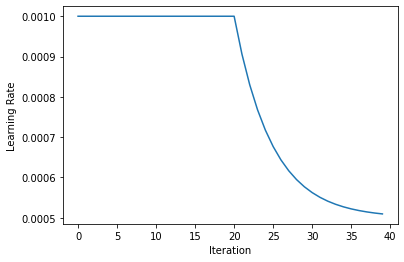

In [ ]:
lrs=[compute_lrg(i, EPOCHS, 0.5*LRG,LRG) for i in range(EPOCHS)]
plt.plot(lrs)
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')

Let's initialize the net.

In [ ]:
from tensorflow.keras.optimizers import RMSprop, Adam

model=Bayes_DfpNet(expo=3,flipout=True,kl_scaling=KL_PREF*len(X_train)/BATCH_SIZE)
optimizer = Adam(learning_rate=LRG, beta_1=0.5,beta_2=0.9999)

num_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
print('Our Bayesian U-Net has {} parameters.'.format(num_params))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Our Bayesian U-Net has 133475 parameters.


Due to some differences in the implementation, the number of parameters is slightly lower than in the conventional neural network (147555), even though we use the same `expo` parameter. In general, flipout layers however come with twice as many parameters compared to their conventional counterparts, since instead of a single point estimate one has to learn both mean and variance parameters (for a Gaussian posterior).

Now we are ready to train!

## Training

In [ ]:
from tensorflow.keras.losses import mae
import math

kl_losses=[]
mae_losses=[]
total_losses=[]
mae_losses_vali=[]

for epoch in range(EPOCHS):
    # compute learning rate - decay is implemented
    currLr = compute_lrg(epoch,EPOCHS,0.5*LRG,LRG)
    if currLr < LRG:
            tf.keras.backend.set_value(optimizer.lr, currLr)

    # iterate through training data 
    kl_sum = 0
    mae_sum = 0
    total_sum=0
    for i, traindata in enumerate(dataset, 0):
      # forward pass and loss computation
        with tf.GradientTape() as tape:
            inputs, targets = traindata
            prediction = model(inputs, training=True)
            loss_mae = tf.reduce_mean(mae(prediction, targets))
            kl=sum(model.losses)
            loss_value=kl+tf.cast(loss_mae, dtype='float32')
        # backpropagate gradients and update parameters 
        gradients = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
   
        # store losses per batch
        kl_sum += kl
        mae_sum += tf.reduce_mean(loss_mae)
        total_sum+=tf.reduce_mean(loss_value)

    # store losses per epoch
    kl_losses+=[kl_sum/len(dataset)]
    mae_losses+=[mae_sum/len(dataset)]
    total_losses+=[total_sum/len(dataset)]

    # validation
    outputs = model.predict(X_val)
    mae_losses_vali += [tf.reduce_mean(mae(y_val, outputs))]

    if epoch<3 or epoch%20==0:
        print('Epoch {}, total loss: {:.3f}, KL loss: {:.3f}, MAE loss: {:.4f}, MAE loss vali: {:.4f}'.format(epoch, total_losses[-1], kl_losses[-1], mae_losses[-1], mae_losses_vali[-1]))

    

Epoch 0, total loss: 0.7221238017082214, KL loss: 0.5655828714370728, MAE loss: 0.15654096501349035, MAE loss vali: 0.08218558877706528
Epoch 1, total loss: 0.6419095993041992, KL loss: 0.5627672672271729, MAE loss: 0.07914231362674123, MAE loss vali: 0.06348632276058197
Epoch 2, total loss: 0.6234583258628845, KL loss: 0.5594442486763, MAE loss: 0.0640141065106364, MAE loss vali: 0.058887988328933716
Epoch 20, total loss: 0.5101600289344788, KL loss: 0.47781607508659363, MAE loss: 0.032343925065392805, MAE loss vali: 0.028796236962080002


The model is trained! Let's look at the loss. Since the loss consists of two separate parts, it is helpful to monitor both parts (MAE and KL).

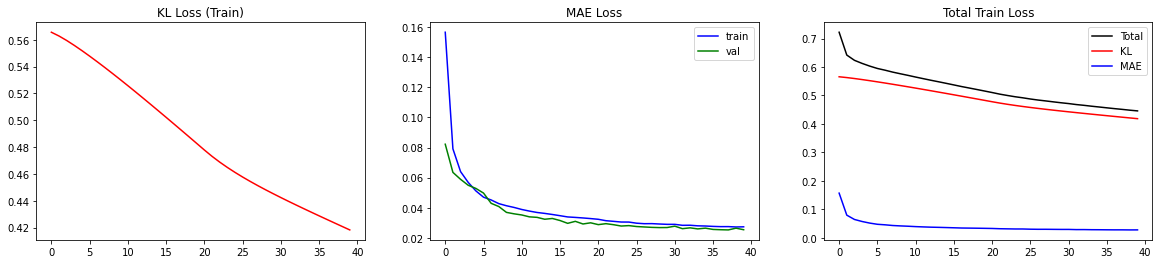

In [ ]:
fig,axs=plt.subplots(ncols=3,nrows=1,figsize=(20,4))
axs[0].plot(kl_losses,color='red')
axs[0].set_title('KL Loss (Train)')
axs[1].plot(mae_losses,color='blue',label='train')
axs[1].plot(mae_losses_vali,color='green',label='val')
axs[1].legend()
axs[1].set_title('MAE Loss')
axs[2].plot(total_losses,label='Total',color='black')
axs[2].plot(kl_losses,label='KL',color='red')
axs[2].plot(mae_losses,label='MAE',color='blue')
axs[2].set_title('Total Train Loss')
axs[2].legend()

This way, we can double-check if minimizing one part of the loss comes at the cost of increasing the other. For our case, we observe that both parts decrease smoothly. In particular, the MAE loss is not increasing for the validation set, indicating that we are not overfitting. 

It is good practice to double-check how many layers added KL-losses. We can inspect _model.losses_ for that. Since the decoder consists of 6 sequential blocks with flipout layers, we expect 6 entries in _model.losses_.

In [ ]:
# there should be 6 entries in model.losses since we have 6 blocks with flipout layers in our model
print('There are {} entries in model.losses'.format(len(model.losses)))
print(model.losses)

There are 6 entries in model.losses
[<tf.Tensor: shape=(), dtype=float32, numpy=0.04792168>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0920701>, <tf.Tensor: shape=(), dtype=float32, numpy=0.18086655>, <tf.Tensor: shape=(), dtype=float32, numpy=0.05210149>, <tf.Tensor: shape=(), dtype=float32, numpy=0.028553702>, <tf.Tensor: shape=(), dtype=float32, numpy=0.015506006>]


Now let's visualize how the BNN performs for unseen data from the validation set. Ideally, we would like to integrate the parameters $\theta$ out, i.e. marginalize in order to obtain a prediction. Since this is again hard to realize analytically, one usually approximates the integral via sampling from the posterior:

$\hat{y_{i}}=\int f(x_{i};\theta)q_{\phi}(\theta)d\theta\approx\frac{1}{R}\sum_{r=1}^{R}f(x_{i};\theta_{r})$ 

where each $\theta_{r}$ is drawn from $q_{\phi}(\theta)$. In practice, this thus just means performing $R$ forward passes for each input $x_{i}$ and computing the average. In the same spirit, one can obtain the standard deviation as a measure of uncertainty:
$\sigma_{i}^{2} = \frac{1}{R-1}\sum_{r=1}^{R}(f(x_{i};\theta)-\hat{y_{i}})^{2}$.

Please note that both $\hat{y_{i}}$ and $\sigma_{i}^{2}$ still have shape $128\times128\times3$, i.e. the mean and variance computations are performed _per-pixel_ (but might be aggregated to a global measure afterwards).

In [ ]:
REPS=20
preds=np.zeros(shape=(REPS,)+X_val.shape)
for rep in range(REPS):
    preds[rep,:,:,:,:]=model.predict(X_val)
preds_mean=np.mean(preds,axis=0)
preds_std=np.std(preds,axis=0)

In the plot, the input is shown in the first row. The second row illustrates the result of a single forward pass. 


In [1]:
NUM=16
# show a single prediction
showSbs(y_val[NUM],preds[0][NUM], top="Inputs", bottom="Single forward pass")


First Row: Inputs, Second row: Single forward Pass


NameError: name 'showSbs' is not defined

We can visualize the uncertainty over predictions more clearly by inspecting several samples from the posterior distribution  as well as the standard deviation for a given input. Below is code for a function that visualizes precisely that (uncertainty is shown with a different colormap in order to illustrate the differences to previous non-bayesian notebook).

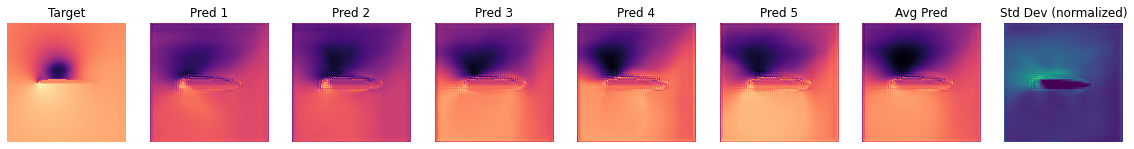

In [ ]:
# plot repeated samples from posterior for some observations
def plot_BNN_predictions(target, preds, pred_mean, pred_std, num_preds=5,channel=0):
  if num_preds>len(preds):
    print('num_preds was set to {}, but has to be smaller than the length of preds. Setting it to {}'.format(num_preds,len(preds)))
    num_preds = len(preds)

  # transpose and concatenate the frames that are to plot
  to_plot=np.concatenate((target[:,:,channel].transpose().reshape(128,128,1),preds[0:num_preds,:,:,channel].transpose(), 
                          pred_mean[:,:,channel].transpose().reshape(128,128,1),pred_std[:,:,channel].transpose().reshape(128,128,1)),axis=-1)
  fig, axs = plt.subplots(nrows=1,ncols=to_plot.shape[-1],figsize=(20,4))
  for i in range(to_plot.shape[-1]):
    label='Target' if i==0 else ('Avg Pred' if i == (num_preds+1) else ('Std Dev (normalized)' if i == (num_preds+2) else 'Pred {}'.format(i)))
    colmap = cm.viridis if i==to_plot.shape[-1]-1 else cm.magma
    frame = np.flipud(to_plot[:,:,i])
    min=np.min(frame); max = np.max(frame)
    frame -= min; frame /=(max-min)
    axs[i].imshow(frame,cmap=colmap)
    axs[i].axis('off')
    axs[i].set_title(label)

OBS_IDX=5
plot_BNN_predictions(y_val[OBS_IDX,...],preds[:,OBS_IDX,:,:,:],preds_mean[OBS_IDX,...],preds_std[OBS_IDX,...])

We are looking at channel 0, i.e. the pressure here. One can observe that the dark and bright regions vary quite a bit across predictions. It is reassuring to note that - at least from visual inspection - the average (i.e. marginal) prediction is closer to the target than most of the single forward passes. 

It should also be noted that each frame was normalized for the visualization. Therefore, when looking at the uncertainty frame, we can inferr where the network is uncertain, but now how uncertain it is in absolute values. 

In order to assess a global measure of uncertainty we can however compute an average standard deviation over all samples in the validation set.

In [ ]:
# Average Prediction with total uncertainty
uncertainty_total = np.mean(np.abs(preds_std),axis=(0,1,2))
preds_mean_global = np.mean(np.abs(preds),axis=(0,1,2,3))
print("\nAverage pixel prediction on validation set: \n pressure: {} +- {}, \n ux: {} +- {},\n uy: {} +- {}".format(np.round(preds_mean_global[0],3),np.round(uncertainty_total[0],3),np.round(preds_mean_global[1],3),np.round(uncertainty_total[1],3),np.round(preds_mean_global[2],3),np.round(uncertainty_total[2],3)))



Average pixel prediction on validation set: 
 pressure: 0.023 +- 0.006, 
 ux: 0.465 +- 0.012,
 uy: 0.08 +- 0.012


## Test evaluation

Like in the case for a conventional neural network, let's now look at **proper** test samples, i.e. OOD samples, for which in this case we'll use new airfoil shapes. These are shapes that the network never saw in any training samples, and hence it tells us a bit about how well the model generalizes to new shapes.

As these samples are at least slightly OOD, we can draw conclusions about how well the model generalizes, which the validation data would not really tell us. In particular, we would like to investigate if the model is more uncertain when handling OOD data.

In [ ]:
if not os.path.isfile('data-airfoils-test.npz'):
  import urllib.request
  url="https://ge.in.tum.de/download/2019-deepFlowPred/data_test.npz"
  print("Downloading test data, this should be fast...")
  urllib.request.urlretrieve(url, 'data-airfoils-test.npz')

nptfile=np.load('data-airfoils-test.npz')
print("Loaded {}/{} test samples".format(len(nptfile["test_inputs"]),len(nptfile["test_targets"])))

Loaded 10/10 test samples


In [ ]:
X_test = np.moveaxis(nptfile["test_inputs"],1,-1)
y_test = np.moveaxis(nptfile["test_targets"],1,-1)

REPS=10
preds_test=np.zeros(shape=(REPS,)+X_test.shape)
for rep in range(REPS):
    preds_test[rep,:,:,:,:]=model.predict(X_test)
preds_test_mean=np.mean(preds_test,axis=0)
preds_test_std=np.std(preds_test,axis=0)
test_loss = tf.reduce_mean(mae(preds_test_mean, y_test))

print("\nAverage test error: {}".format(test_loss))



Average test error: 0.030517476765238794


In [ ]:
# Average Prediction with total uncertainty
uncertainty_test_total = np.mean(np.abs(preds_test_std),axis=(0,1,2))
preds_test_mean_global = np.mean(np.abs(preds_test),axis=(0,1,2,3))
print("\nAverage pixel prediction on test set: \n pressure: {} +- {}, \n ux: {} +- {},\n uy: {} +- {}".format(np.round(preds_test_mean_global[0],3),np.round(uncertainty_test_total[0],3),np.round(preds_test_mean_global[1],3),np.round(uncertainty_test_total[1],3),np.round(preds_test_mean_global[2],3),np.round(uncertainty_test_total[2],3)))



Average pixel prediction on test set: 
 pressure: 0.025 +- 0.007, 
 ux: 0.463 +- 0.013,
 uy: 0.088 +- 0.014


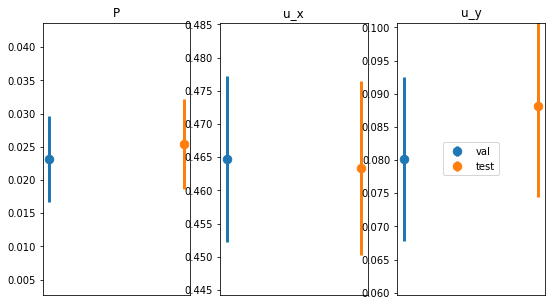

In [ ]:
# plot average pixel predictions with uncertainty
max_unc = max(max(uncertainty_test_total),max(uncertainty_total))
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(9,5))
for channel in range(3):
  title = 'P' if channel ==0 else ('u_x' if channel ==1 else 'u_y')
  axs[channel].errorbar(0.5,preds_mean_global[channel],uncertainty_total[channel],linestyle='none',marker='o',markersize=8.5,label='val',linewidth=3.)
  axs[channel].errorbar(1.5,preds_test_mean_global[channel],uncertainty_test_total[channel],linestyle='none',marker='o',markersize=8.5,label='test',linewidth=3.)
  axs[channel].set_title(title)
  axs[channel].tick_params(
      axis='x',          # changes apply to the x-axis
      which='both',      # both major and minor ticks are affected
      bottom=False,      # ticks along the bottom edge are off
      top=False,         # ticks along the top edge are off
      labelbottom=False)
  axs[channel].set_ylim(preds_mean_global[channel]-1.5*max_unc,preds_mean_global[channel]+1.5*max_unc)
axs[2].legend(loc='center')

This is reassuring: The error on the OOD test set with new shapes is higher than on the validation set. However, also the uncertainty is larger.
In general it is hard to obtain a calibrated uncertainty estimate, but since we are dealing with a fairly simple problem here, it seems that the BNN could estimate it reasonably well.

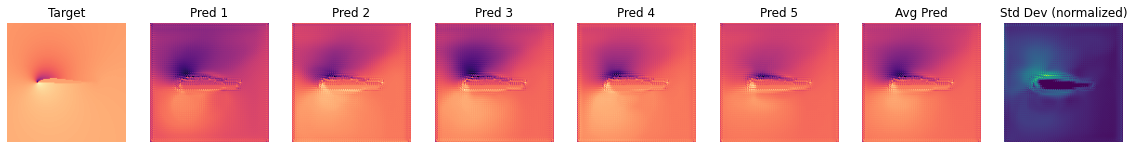

In [ ]:
OBS_IDX=5
plot_BNN_predictions(y_test[OBS_IDX,...],preds_test[:,OBS_IDX,:,:,:],preds_test_mean[OBS_IDX,...],preds_test_std[OBS_IDX,...])

We can visualize several shapes from the test set together with the corresponding marginalized prediction and uncertainty.

Text(0.5, 1.0, 'Std. Dev')

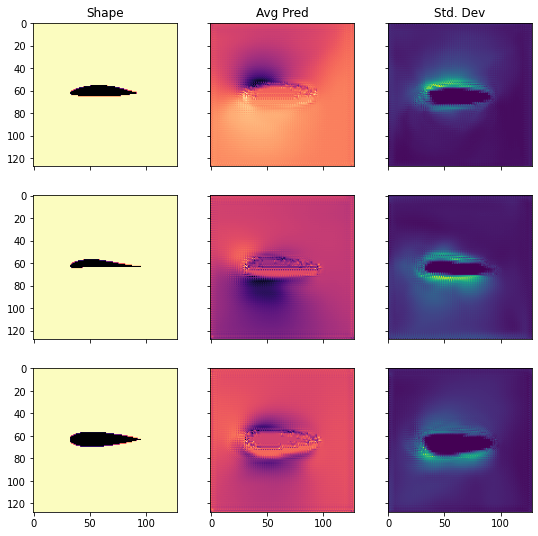

In [ ]:
IDXS = [1,3,8]
CHANNEL = 0
fig, axs = plt.subplots(nrows=len(IDXS),ncols=3,sharex=True, sharey = True, figsize = (9,len(IDXS)*3))
for i, idx in enumerate(IDXS):
  axs[i][0].imshow(np.flipud(X_test[idx,:,:,CHANNEL].transpose()), cmap=cm.magma)
  axs[i][1].imshow(np.flipud(preds_test_mean[idx,:,:,CHANNEL].transpose()), cmap=cm.magma)
  axs[i][2].imshow(np.flipud(preds_test_std[idx,:,:,CHANNEL].transpose()), cmap=cm.viridis)
axs[0][0].set_title('Shape')
axs[0][1].set_title('Avg Pred')
axs[0][2].set_title('Std. Dev')


As we can see, the shapes from the test set differ quite a bit from another. Nevertheless, the uncertainty estimate is reasonably distributed. This is, for every shape the bulk of uncertainty is located around the shape where one expects the most turbulent flow. 

Despite these promising results, there are still several issues with Bayesian Neural Nets, limiting their use in many practical applications. One serious drawback is the need for additional scaling of the KL-loss and the fact that there is no convincing argument on why it is necessary yet (read e.g. [here](http://proceedings.mlr.press/v119/wenzel20a/wenzel20a.pdf) or [here](https://arxiv.org/abs/2008.05912)).
Furthermore, some people think that assuming independent normal distributions as variational approximations to the posterior is an oversimplification since in practice the weights are actually highly correlated ([paper](https://arxiv.org/abs/1909.00719)). Other people instead argue that this might not be an issue, as long as the networks in use are deep enough ([paper](https://arxiv.org/abs/2002.03704)). On top of that, there is research on different (e.g. heavy-tailed) priors other than normals and many other aspects of BNNs.

## Next Steps 

* Exercise I: 
But now it's time to experiment with BNNs yourself! One interesting thing to look at is how the behaviour of our model changes, if we adjust the KL-prefactor. In the training loop above we set it to 5000 without further justification. You can check out what happens, if you use a value of 1, as it is suggested by the theory, instead of 5000. According to our implementation, this should make the model 'more bayesian', since we assign larger importance to the KL-divergence than before. 

* Exercise II:
So far, we have only worked with variational BNNs, implemented via TensorFlows probabilistic layers. Recall that there is a simpler way of getting uncertainty estimates, too: Using dropout not only at training, but also at inference time. You can check out how the outputs change for that case. In order to do so, you can, for instance, just pass a non-zero dropout rate to the model specification and change the prediction phase in the above implementation from _model.predict(...)_ to _model(..., training=True)_. Setting the _training=True_ flag will tell TensorFlow to forward the input as if it were training data and hence, it will apply dropout. Please note that the _training=True_ flag can also affect other features of the network. Batchnorm, for instance, works differently in training and prediction mode. As long as we don't deal with OOD data and use sufficiently large batch-sizes, this should not have too large of an effect, though. Sensible dropout rates to start experimenting with are e.g. around 0.1.